In [405]:
import pandas as pd
import os
import time

# work with directories
from pathlib import Path 

# datetime
#import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# work with data
import numpy as np

# visualize data
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# create bag of word vector
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sktime.forecasting.arima import ARIMA, AutoARIMA

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

## Import data

In [526]:
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

df_og = pd.read_csv(os.path.abspath(parent_path + '/data/preprocessed_df.csv'))


print(df_og.shape)
df_og.isna().sum().sum()

(79875, 110)


0

In [527]:
unit_of_analyis = 'isocode'

def make_target(df: pd.DataFrame, shifter: int, target: str): # t is the number of periods for the shift

    # loop through each period and generate the shift variables
    for i in range(1, shifter+1):
        col_name = f'{target}{i}' # name doesn't matter, just interimset str(target) + f'{i}' # 

        df[col_name] = df.groupby(unit_of_analyis)[str(target)].shift(-i)

    # take the maximum for t periods forward and create the new variable
    df['target_clsf_f{}'.format(shifter)] = df[[f'{target}{i}' for i in range(1, shifter+1)]].max(axis=1, skipna=False)

    # drop the shift variables
    df = df.drop(columns=[f'{target}{i}' for i in range(1, shifter+1)])
    
    return(df)

In [535]:
shifter = 3
target_clsf = 'armedconf'
target_regr = 'deaths_all_pc'

df_exmpl = df_og.copy()

# generate binary classification  target
df_exmpl = make_target(df_exmpl, shifter, target_clsf)

# generate regression target
df_exmpl[f'target_regr_f{shifter}'] = df_exmpl.groupby(unit_of_analyis)[target_regr].shift(-shifter)

# check it worked
df_exmpl.loc[df_exmpl['isocode'] == 'BFA', ['Country Name','year', 'deaths', 'wb_pop', 'deaths_all_pc', 'deaths_state_pc', 'armedconf', 'civilwar', f'target_clsf_f{shifter}', f'target_regr_f{shifter}']][-8:]

,Country Name,year,deaths,wb_pop,deaths_all_pc,deaths_state_pc,armedconf,civilwar,target_clsf_f3,target_regr_f3
78328,Burkina Faso,2022,105.0,22100683.0,0.475098,0.475098,True,False,1.0,0.000000
78523,Burkina Faso,2022,203.0,22100683.0,0.918524,0.918524,True,False,1.0,2.149255
78718,Burkina Faso,2022,195.0,22100683.0,0.882326,0.882326,True,False,1.0,2.533858
78913,Burkina Faso,2023,0.0,22100683.0,0.000000,0.000000,False,False,1.0,0.000000
79108,Burkina Faso,2023,475.0,22100683.0,2.149255,2.149255,True,False,1.0,0.000000
79303,Burkina Faso,2023,560.0,22100683.0,2.533858,2.533858,True,False,NaN,NaN
79498,Burkina Faso,2023,0.0,22100683.0,0.000000,0.000000,False,False,NaN,NaN
79693,Burkina Faso,2023,0.0,22100683.0,0.000000,0.000000,False,False,NaN,NaN


## Model
- Prepare slice function
- Set parameters for Random Forest classifier and regressor
- Run the biog loop: once for classifier, once for regressor

In [533]:
df = df_og.copy()
df.columns

Index(['MonthYear', 'isocode', 'month', 'year', 'deaths', 'state_deaths',
       'nonstate_deaths', 'onesided_deaths', 'civilian_deaths', 'month_year',
       ...
       'civilwar', 'past6', 'past12', 'past60', 'past120', 'armedconf_since',
       'num_regions', 'Adm1_Max', 'Adm1_Mean', 'Adm1_Median'],
      dtype='object', length=110)

In [551]:
df['month_year'] = pd.to_datetime(df['month_year'])


### Prepare slice

In [585]:
# Columns dropped while fitting, but added to identify predictions

time_var = ['month_year']
id_var = ['isocode']

# Lists of variables to keep for each model (NB past currently only based on total number of deaths per )

historical_vars = ['deaths_all_pc', 'armedconf', 'past6', 'past12', 'past60', 'past120','armedconf_since']

old_eventshare_names = ['event_share_{}'.format(i) for i in range(1, 21)]
new_eventshare_names = ['share_events_count_events_{}'.format(i) for i in range(1, 21)]

text_gdelt_shares = ['norm_total_events'] + new_eventshare_names
text_gdelt_stocks = ['event_share_{}_stock'.format(i) for i in range(1, 21)]
text_gdelt_admin1 = ['num_regions', 'Adm1_Max', 'Adm1_Mean', 'Adm1_Median']

text_gdelt_vars = text_gdelt_shares + text_gdelt_admin1 #+text_gdelt_stocks

other_vars = ['deaths','state_deaths', 'nonstate_deaths', 'onesided_deaths', 'civilian_deaths'] #['IncomeGroup', 'Region']


#text_gdelt_stocks = ['event_share_1_stock', 'event_share_2_stock',
#        'event_share_3_stock', 'event_share_4_stock', 'event_share_5_stock',
#        'event_share_6_stock', 'event_share_7_stock', 'event_share_8_stock',
#        'event_share_9_stock', 'event_share_10_stock', 'event_share_11_stock',
#        'event_share_12_stock', 'event_share_13_stock', 'event_share_14_stock',
#        'event_share_15_stock', 'event_share_16_stock', 'event_share_17_stock',
#        'event_share_18_stock', 'event_share_19_stock', 'event_share_20_stock']


In [586]:
# Decide within prepare slice which columns to include for each model and adjust these lengths accordingly
# They allow us to keep track of feature importance, an addition we made to Hannes's original code
combomodel_var_len = len(historical_vars + text_gdelt_vars) 
historymodel_var_len = len(historical_vars) 
textmodel_varl_len = len(text_gdelt_vars)

In [587]:
def prepare_slice(df, date, target, forward, binary = True):
    df = df.copy()

    # Establish past: keep only what is before the current year 
    data = df[df.month_year < date]
    print('pre drop data: ', len(data))

    # Establish future: keep only currrent time period, which is to be predicted 
    future = df[df.month_year == date]	
    print('pre drop future: ', len(future))

    # generate the shifted target
    # define the dependent variables as generated by the make_target function (for binary) or pure shifter (for regression)
    if binary:
        data_target = make_target(df=data, shifter=forward, target=target)
        
        # When this is used in the loop later, we will predice forward 1 and 2 business days
        deps=['target_clsf_f{}'.format(forward)] 

    else:
        data_target = data.groupby(unit_of_analyis)[target].shift(-forward)
        deps=['target_regr_f{}'.format(forward)] 


    # choose which data to keep for which model
    # X-vars
    combomodel = historical_vars + text_gdelt_vars 
    historymodel = historical_vars
    textmodel = text_gdelt_vars 

    # full columns with X-vars, y-var and id-vars
    combomodel_all = combomodel + id_var + time_var + deps
    historymodel_all = historymodel + id_var + time_var + deps
    textmodel_all = textmodel + id_var + time_var + deps

    # Model 1: Full or augmented/ combined model
    df_all = data[combomodel_all].dropna()
    print('post drop model: ', len(df_all)) # the others have the same length
    y_all = df_all[deps].values.ravel() # all models have the same target

    # Model 2: History model 
    df_hs = data[historymodel_all].dropna()

    # Model 3: Pure text-based (novelty) model
    df_tx = data[textmodel_all].dropna()
    
    # Training data: X-vars - no Ticker or Date, NaNs already dropped
    X_all = df_all[combomodel]
    X_hs = df_hs[historymodel]
    X_tx = df_tx[textmodel]

    # Remove dependent variable from column lists - still includes Date and Ticker
    combomodel_all.remove(deps[0])
    historymodel_all.remove(deps[0])
    textmodel_all.remove(deps[0])

    # Use these columns for the future (out-of-sample) data for the models
    df_fut_all = future[combomodel_all].dropna()
    df_fut_hs = future[historymodel_all].dropna()
    df_fut_tx = future[textmodel_all].dropna()

    # Data (X-vars) at time T for producing fitted values - no Date or Ticker
    X_fut_all = df_fut_all[combomodel]
    X_fut_hs = df_fut_hs[historymodel]
    X_fut_tx = df_fut_tx[textmodel]

    return X_all, X_hs, X_tx, y_all, X_fut_all, X_fut_hs, X_fut_tx, df_all, df_hs, df_tx, df_fut_all, df_fut_hs, df_fut_tx


In [556]:
# Exemplification of prepare slice:
data = df.copy()
start_date = dt.datetime(2018, 1, 1) 

# number of business days ahead to predict (will shorten target frame by forward * number of firms (5))
forward = 2
target_clsf = 'armedconf'
binary_target = True

#apply prepare slice
X_all, X_hs, X_tx, y, X_fut_all, X_fut_hs, X_fut_tx, df_all, df_hs, df_tx, df_fut_all, df_fut_hs, df_fut_tx  = prepare_slice(data, start_date, target_clsf, forward, binary_target)

# Explaning output
print(y.shape)

print('___')
print(df_all.shape)   # all X-vars, other and target
print(df_fut_all.shape) # all X-vars and other, but NO dep - only 1 day

print(X_all.shape)    # no Ticker/date/target and final row removed for all 
print(X_fut_all.shape)  # no Ticker/date/target  - only 1 day

print('___')
print(df_hs.shape)
print(df_fut_hs.shape)

print(X_hs.shape)   
print(X_fut_hs.shape)

print('___')
print(df_tx.shape)
print(df_fut_tx.shape)

print(X_tx.shape)   
print(X_fut_tx.shape)


pre drop data:  67200
pre drop future:  195
post drop model:  66810
(66810,)
___
(66810, 51)
(195, 50)
(66810, 48)
(195, 48)
___
(66810, 10)
(195, 9)
(66810, 7)
(195, 7)
___
(66810, 44)
(195, 43)
(66810, 41)
(195, 41)


### Set parameters

In [557]:
def setparams_regr(treenumber, depthnumber, min_samples_number, min_samples_leaf_number):     
    '''function to set the parameters of the RF model'''
    
    regressor=RandomForestRegressor(n_estimators=treenumber,  max_depth =depthnumber,
                               min_samples_split =min_samples_number, min_samples_leaf =  min_samples_leaf_number,
                             n_jobs=8) 
    return regressor

def setparams_clsf(treenumber, depthnumber, min_samples_number, min_samples_leaf_number):  
    '''function to set the parameters of the RF model'''
    
    classifier=RandomForestClassifier(n_estimators=treenumber,  max_depth =depthnumber, 
                               min_samples_split =min_samples_number, min_samples_leaf =  min_samples_leaf_number
                             ,n_jobs=8, class_weight = 'balanced') #criterion='gini'
    return classifier

In [581]:
# set randomforest variables 

# fixed parameters
trees=700
min_samples_splits=2
min_samples_leafs = 100

# varying parameters
fwd = [1,2] # we predict 1 and 2 months ahead
dpths = [8] # we could use more depths, but this would increase the time in takes to run this code


### Run big loop

Once for classifier, once for regressor.

In [582]:
# specify targets
target_regr = 'deaths_all_pc'
target_clsf = 'armedconf'

# decide on period to predict for
start_month_year = datetime(2018, 1, 1)
end_month_year = datetime(2021,12,1)#(2018, 12, 1)

In [583]:
def generate_monthly_dates(start_month_year, end_month_year):
    current_date = start_month_year.replace(day=1)
    dates = []

    while current_date <= end_month_year:
        dates.append(current_date)
        current_date += relativedelta(months=1)
        
    return dates

# dates = generate_monthly_dates(start_month_year, end_month_year)
# for date in dates:
#      print(date.strftime('%Y-%m-%d'))

#### Run big look for Regressor

In [584]:
# Shorten the data frame 
prepped_data = df.copy()

drop_before = dt.datetime(2000, 1, 1) # instead of starting from 1989
prepped_data = prepped_data[prepped_data.month_year >= drop_before ]

print(target_regr)
prepped_data.shape

deaths_all_pc


(54747, 110)

In [580]:
pd.set_option('display.max_columns', 500)
prepped_data.isna().sum()

for column in prepped_data.columns:
    print(f"{column}: {prepped_data[column].isna().sum()}")

prepped_data.loc[prepped_data['event_share_1_stock'].isna()]

MonthYear: 0
isocode: 0
month: 0
year: 0
deaths: 0
state_deaths: 0
nonstate_deaths: 0
onesided_deaths: 0
civilian_deaths: 0
month_year: 0
Country Name: 0
wb_pop: 0
date: 0
total_events: 0
total_events_gov: 0
total_events_opp: 0
share_events_count_events_1: 0
share_events_count_events_2: 0
share_events_count_events_3: 0
share_events_count_events_4: 0
share_events_count_events_5: 0
share_events_count_events_6: 0
share_events_count_events_7: 0
share_events_count_events_8: 0
share_events_count_events_9: 0
share_events_count_events_10: 0
share_events_count_events_11: 0
share_events_count_events_12: 0
share_events_count_events_13: 0
share_events_count_events_14: 0
share_events_count_events_15: 0
share_events_count_events_16: 0
share_events_count_events_17: 0
share_events_count_events_18: 0
share_events_count_events_19: 0
share_events_count_events_20: 0
share_events_count_events_1_gov: 0
share_events_count_events_2_gov: 0
share_events_count_events_3_gov: 0
share_events_count_events_4_gov: 0
s

,MonthYear,isocode,month,year,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,Country Name,wb_pop,date,total_events,total_events_gov,total_events_opp,share_events_count_events_1,share_events_count_events_2,share_events_count_events_3,share_events_count_events_4,share_events_count_events_5,share_events_count_events_6,share_events_count_events_7,share_events_count_events_8,share_events_count_events_9,share_events_count_events_10,share_events_count_events_11,share_events_count_events_12,share_events_count_events_13,share_events_count_events_14,share_events_count_events_15,share_events_count_events_16,share_events_count_events_17,share_events_count_events_18,share_events_count_events_19,share_events_count_events_20,share_events_count_events_1_gov,share_events_count_events_2_gov,share_events_count_events_3_gov,share_events_count_events_4_gov,share_events_count_events_5_gov,share_events_count_events_6_gov,share_events_count_events_7_gov,share_events_count_events_8_gov,share_events_count_events_9_gov,share_events_count_events_10_gov,share_events_count_events_11_gov,share_events_count_events_12_gov,share_events_count_events_13_gov,share_events_count_events_14_gov,share_events_count_events_15_gov,share_events_count_events_16_gov,share_events_count_events_17_gov,share_events_count_events_18_gov,share_events_count_events_19_gov,share_events_count_events_20_gov,share_events_count_events_1_opp,share_events_count_events_2_opp,share_events_count_events_3_opp,share_events_count_events_4_opp,share_events_count_events_5_opp,share_events_count_events_6_opp,share_events_count_events_7_opp,share_events_count_events_8_opp,share_events_count_events_9_opp,share_events_count_events_10_opp,share_events_count_events_11_opp,share_events_count_events_12_opp,share_events_count_events_13_opp,share_events_count_events_14_opp,share_events_count_events_15_opp,share_events_count_events_16_opp,share_events_count_events_17_opp,share_events_count_events_18_opp,share_events_count_events_19_opp,share_events_count_events_20_opp,norm_total_events,event_share_1_stock,event_share_2_stock,event_share_3_stock,event_share_4_stock,event_share_5_stock,event_share_6_stock,event_share_7_stock,event_share_8_stock,event_share_9_stock,event_share_10_stock,event_share_11_stock,event_share_12_stock,event_share_13_stock,event_share_14_stock,event_share_15_stock,event_share_16_stock,event_share_17_stock,event_share_18_stock,event_share_19_stock,event_share_20_stock,deaths_all_pc,deaths_state_pc,armedconf,civilwar,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median


For target deaths_all_pc: checking forward 1 with depth 8
Setting parameters
Month:  2018-01-01 00:00:00
pre drop data:  42072
pre drop future:  195
post drop model:  41877
Month:  2018-02-01 00:00:00
pre drop data:  42267
pre drop future:  195
post drop model:  42072
Month:  2018-03-01 00:00:00
pre drop data:  42462
pre drop future:  195
post drop model:  42267
Month:  2018-04-01 00:00:00
pre drop data:  42657
pre drop future:  195
post drop model:  42462
Month:  2018-05-01 00:00:00
pre drop data:  42852
pre drop future:  195
post drop model:  42657
Month:  2018-06-01 00:00:00
pre drop data:  43047
pre drop future:  195
post drop model:  42852
Month:  2018-07-01 00:00:00
pre drop data:  43242
pre drop future:  195
post drop model:  43047
Month:  2018-08-01 00:00:00
pre drop data:  43437
pre drop future:  195
post drop model:  43242
Month:  2018-09-01 00:00:00
pre drop data:  43632
pre drop future:  195
post drop model:  43437
Month:  2018-10-01 00:00:00
pre drop data:  43827
pre drop 

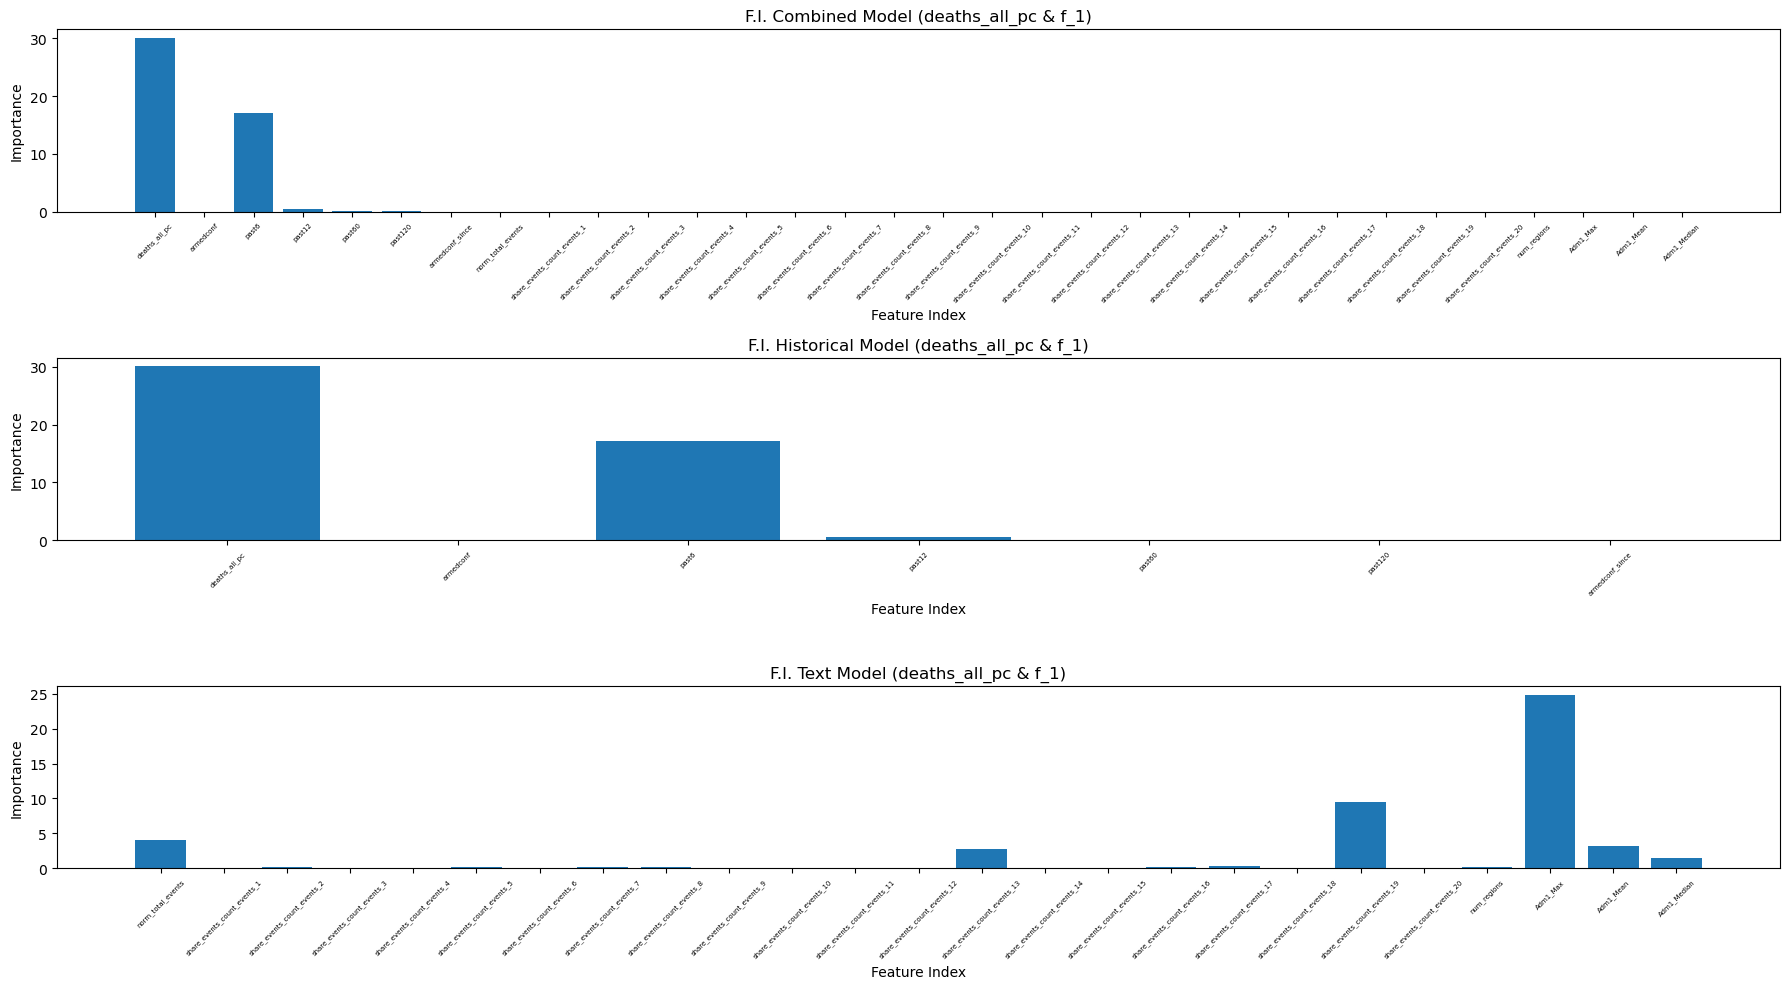

For target deaths_all_pc: checking forward 2 with depth 8
Setting parameters
Month:  2018-01-01 00:00:00
pre drop data:  42072
pre drop future:  195
post drop model:  41682
Month:  2018-02-01 00:00:00
pre drop data:  42267
pre drop future:  195
post drop model:  41877
Month:  2018-03-01 00:00:00
pre drop data:  42462
pre drop future:  195
post drop model:  42072
Month:  2018-04-01 00:00:00
pre drop data:  42657
pre drop future:  195
post drop model:  42267
Month:  2018-05-01 00:00:00
pre drop data:  42852
pre drop future:  195
post drop model:  42462
Month:  2018-06-01 00:00:00
pre drop data:  43047
pre drop future:  195
post drop model:  42657
Month:  2018-07-01 00:00:00
pre drop data:  43242
pre drop future:  195
post drop model:  42852
Month:  2018-08-01 00:00:00
pre drop data:  43437
pre drop future:  195
post drop model:  43047
Month:  2018-09-01 00:00:00
pre drop data:  43632
pre drop future:  195
post drop model:  43242
Month:  2018-10-01 00:00:00
pre drop data:  43827
pre drop 

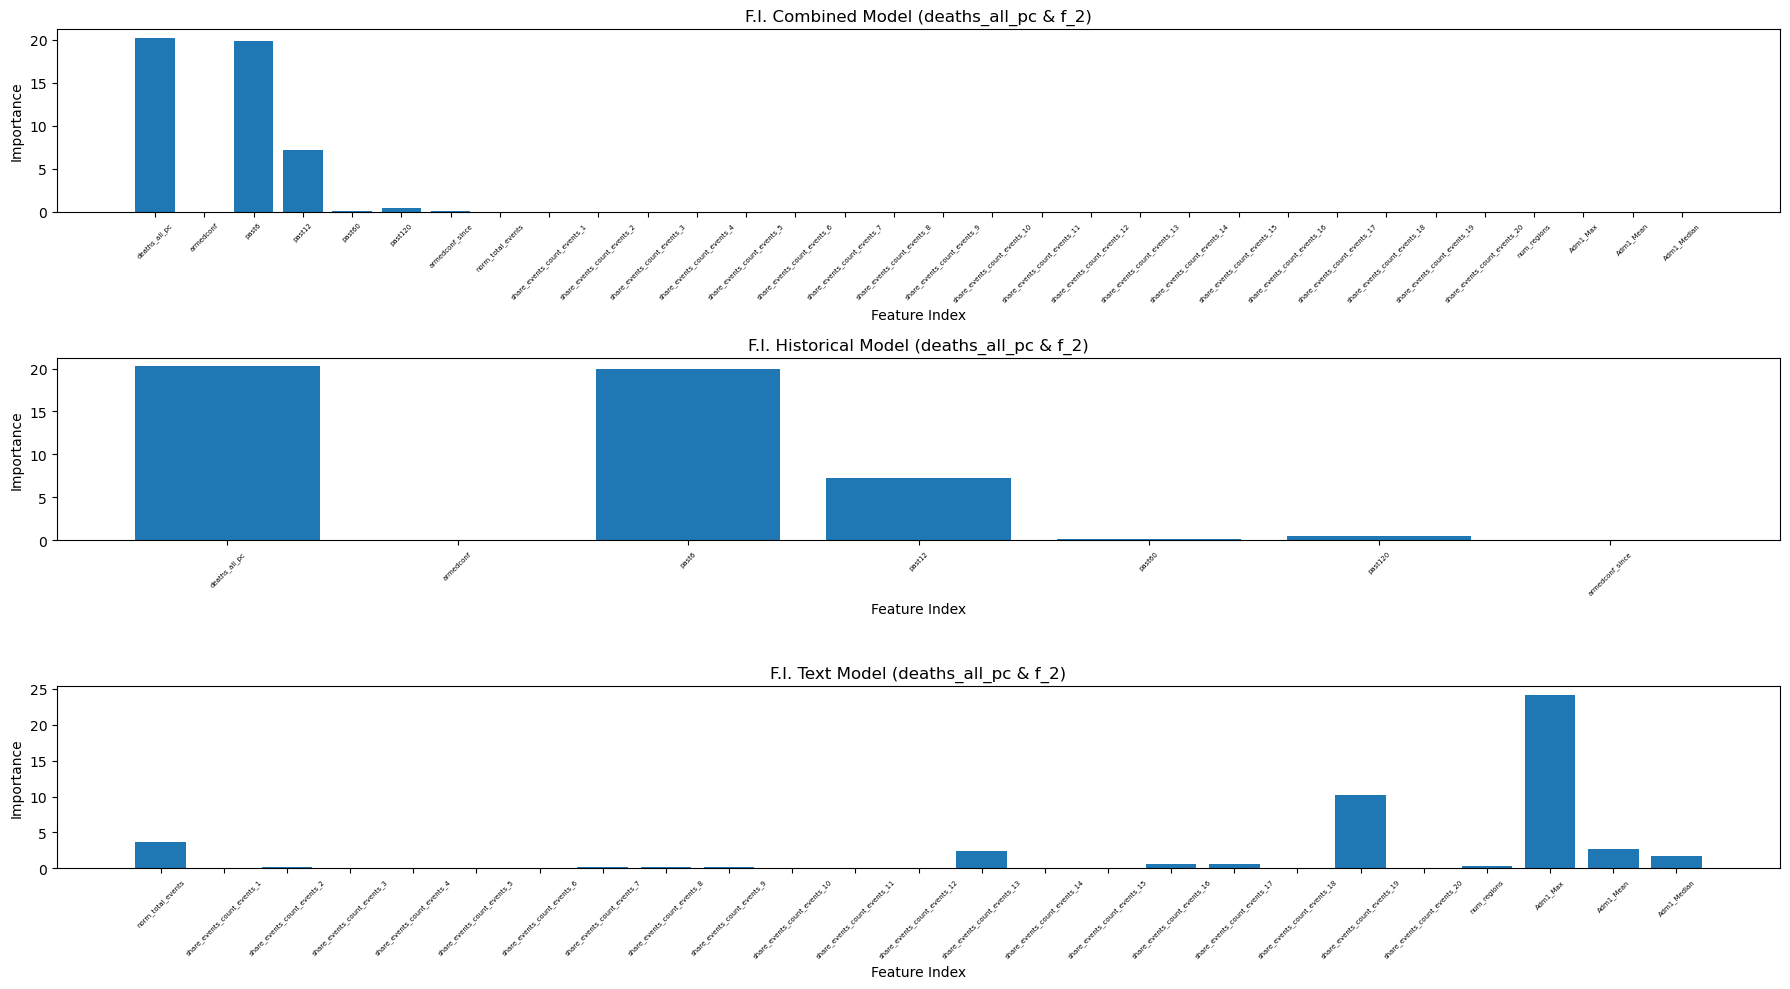

In [588]:
for dep in [target_regr]: # we only have one dependent variable: stock price changes

    for forward,depth in zip(fwd,dpths):

        #for dp in depths:
        for forward in fwd:

            fittedframe = pd.DataFrame(columns=id_var + time_var)

            print(f'For target {dep}: checking forward {forward} with depth {depth}')
            
            print('Setting parameters')
            RF_all = setparams_regr(trees, depth, min_samples_splits, min_samples_leafs)
            RF_hs = setparams_regr(trees, depth, min_samples_splits, min_samples_leafs)
            RF_tx = setparams_regr(trees, depth, min_samples_splits, min_samples_leafs)

            # to keep track of feature importances for each model (all, hs, tx)
            accumulated_importances_all = [0] * combomodel_var_len
            accumulated_importances_hs = [0] * historymodel_var_len
            accumulated_importances_tx = [0] * textmodel_varl_len

            
            # generates list of all working days between start and end date  
            #business_day_dates = generate_business_day_dates(startdate_id, end_date, [])

            # generate list of all months between start and end date
            future_months = generate_monthly_dates(start_month_year, end_month_year)
    
            for current_date in future_months:
                print('Month: ', current_date)
                
                # prepare slice for the current year and dep variable
                X_all, X_hs, X_tx, y, X_fut_all, X_fut_hs, X_fut_tx, df_all, df_hs, df_tx, df_fut_all, df_fut_hs, df_fut_tx  = prepare_slice(prepped_data, current_date, dep, forward, binary = True)

                # fit the model to the relevant X and y data
                RF_all.fit(X_all, y) # .astype(int) - when using classifier
                RF_hs.fit(X_hs, y)
                RF_tx.fit(X_tx, y)

                # add feature importances to the accumulated list
                importances_all = RF_all.feature_importances_
                importances_hs = RF_hs.feature_importances_
                importances_tx = RF_tx.feature_importances_

                accumulated_importances_all += importances_all
                accumulated_importances_hs += importances_hs
                accumulated_importances_tx += importances_tx

                # predict the future data for each model
                results_all = RF_all.predict(X_fut_all) # predict_proba(X_fut_all) - when using classifier
                results_hs = RF_hs.predict(X_fut_hs)
                results_tx = RF_tx.predict(X_fut_tx)

                # prepare data frames and add the prediction results for each model 
                pred_fut_all = df_fut_all[id_var + time_var]
                pred_fut_hs = df_fut_hs[id_var + time_var]
                pred_fut_tx = df_fut_tx[id_var + time_var]

                pred_fut_all[f'pred_{dep}_f{forward}_all'] = results_all[:] # if predict_proba [:,1]
                pred_fut_hs[f'pred_{dep}_f{forward}_hs'] = results_hs[:]
                pred_fut_tx[f'pred_{dep}_f{forward}_tx'] = results_tx[:]

                # comnbine the results
                pred_future=pd.merge(pred_fut_all,pred_fut_hs,on=id_var+time_var,how='outer')
                pred_future=pd.merge(pred_future,pred_fut_tx,on=id_var+time_var,how='outer')
                
                # add each year's results to the fittedframe:
                fittedframe=pd.concat([fittedframe,pred_future])
            
            # save predictions for three models to csv before moving to next target (dep) and shifter (forward)
            fittedframe.to_csv(f"predictions_regr_f{forward}_d{depth}_{dep}.csv")
            print('Saved predictions for forward ', forward, ' and depth ', depth, ' and target ', dep, 'to directory', os.getcwd())

            # plot feature importances for each model
            fig, axs = plt.subplots(3, 1, figsize=(18, 10))
        
            feature_labels_all = X_all.columns
            feature_labels_hs = X_hs.columns
            feature_labels_tx = X_tx.columns

            axs[0].bar(range(combomodel_var_len), accumulated_importances_all)
            axs[0].set_xlabel('Feature Index')
            axs[0].set_ylabel('Importance')
            axs[0].set_title(f'F.I. Combined Model ({dep} & f_{forward})')
            axs[0].set_xticks(range(combomodel_var_len), feature_labels_all,rotation=45, fontsize=5)

            axs[1].bar(range(historymodel_var_len), accumulated_importances_hs)
            axs[1].set_xlabel('Feature Index')
            axs[1].set_ylabel('Importance')
            axs[1].set_title(f'F.I. Historical Model ({dep} & f_{forward})')
            axs[1].set_xticks(range(historymodel_var_len), feature_labels_hs, rotation=45, fontsize=5)

            axs[2].bar(range(textmodel_varl_len), accumulated_importances_tx)
            axs[2].set_xlabel('Feature Index')
            axs[2].set_ylabel('Importance')
            axs[2].set_title(f'F.I. Text Model ({dep} & f_{forward})')
            axs[2].set_xticks(range(textmodel_varl_len), feature_labels_tx, rotation=45, fontsize=5)
            
            plt.tight_layout()
            plt.show()

#### Run big loop for Classifier

In [575]:
# Shorten the data frame 
prepped_data = df.copy()

drop_before = dt.datetime(2000, 1, 1) # instead of starting from 1989
prepped_data = prepped_data[prepped_data.month_year >= drop_before ]

print(target_clsf)
prepped_data.shape

armedconf


(54747, 110)

In [576]:
print(start_month_year, end_month_year)
fwd = [1,2]#, 2]
print(fwd, dpths)
print(target_clsf)



2018-01-01 00:00:00 2021-12-01 00:00:00
[1, 2] [8]
armedconf


For target armedconf: checking forward 1 with depth 8
Setting parameters
Month:  2018-01-01 00:00:00
pre drop data:  42072
pre drop future:  195
post drop model:  41877
Month:  2018-02-01 00:00:00
pre drop data:  42267
pre drop future:  195
post drop model:  42072
Month:  2018-03-01 00:00:00
pre drop data:  42462
pre drop future:  195
post drop model:  42267
Month:  2018-04-01 00:00:00
pre drop data:  42657
pre drop future:  195
post drop model:  42462
Month:  2018-05-01 00:00:00
pre drop data:  42852
pre drop future:  195
post drop model:  42657
Month:  2018-06-01 00:00:00
pre drop data:  43047
pre drop future:  195
post drop model:  42852
Month:  2018-07-01 00:00:00
pre drop data:  43242
pre drop future:  195
post drop model:  43047
Month:  2018-08-01 00:00:00
pre drop data:  43437
pre drop future:  195
post drop model:  43242
Month:  2018-09-01 00:00:00
pre drop data:  43632
pre drop future:  195
post drop model:  43437
Month:  2018-10-01 00:00:00
pre drop data:  43827
pre drop futu

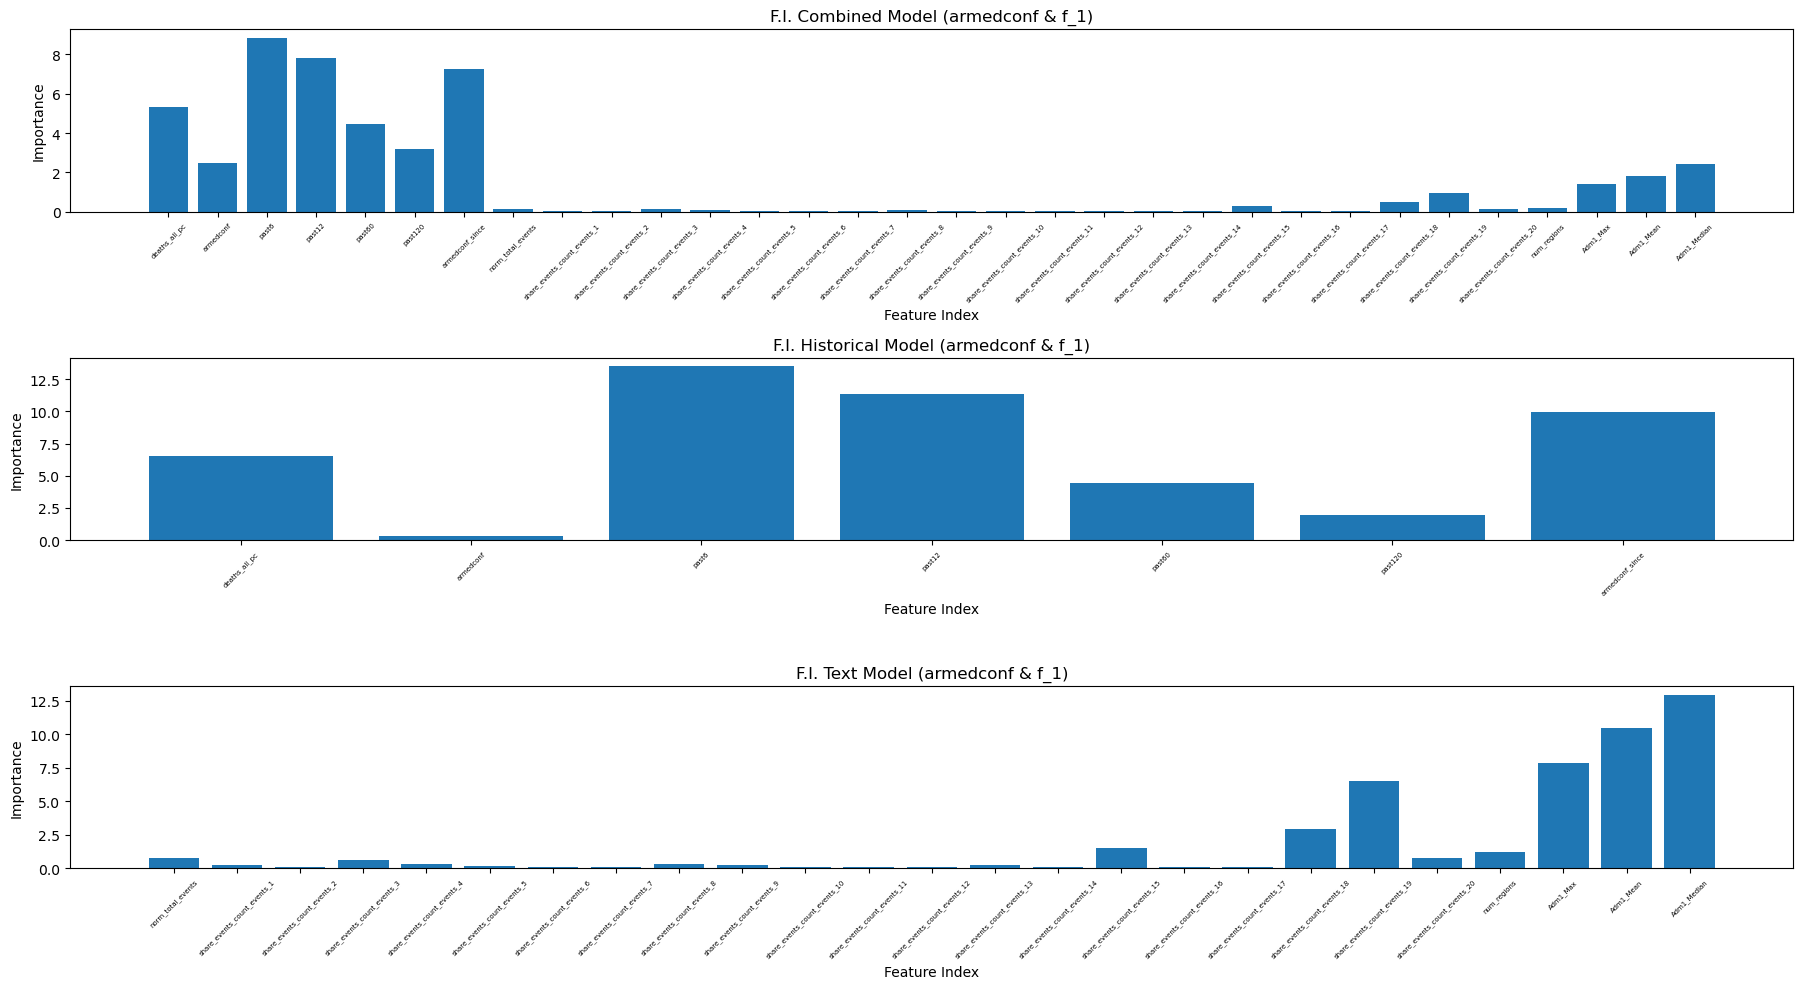

For target armedconf: checking forward 2 with depth 8
Setting parameters
Month:  2018-01-01 00:00:00
pre drop data:  42072
pre drop future:  195
post drop model:  41682
Month:  2018-02-01 00:00:00
pre drop data:  42267
pre drop future:  195
post drop model:  41877
Month:  2018-03-01 00:00:00
pre drop data:  42462
pre drop future:  195
post drop model:  42072
Month:  2018-04-01 00:00:00
pre drop data:  42657
pre drop future:  195
post drop model:  42267
Month:  2018-05-01 00:00:00
pre drop data:  42852
pre drop future:  195
post drop model:  42462
Month:  2018-06-01 00:00:00
pre drop data:  43047
pre drop future:  195
post drop model:  42657
Month:  2018-07-01 00:00:00
pre drop data:  43242
pre drop future:  195
post drop model:  42852
Month:  2018-08-01 00:00:00
pre drop data:  43437
pre drop future:  195
post drop model:  43047
Month:  2018-09-01 00:00:00
pre drop data:  43632
pre drop future:  195
post drop model:  43242
Month:  2018-10-01 00:00:00
pre drop data:  43827
pre drop futu

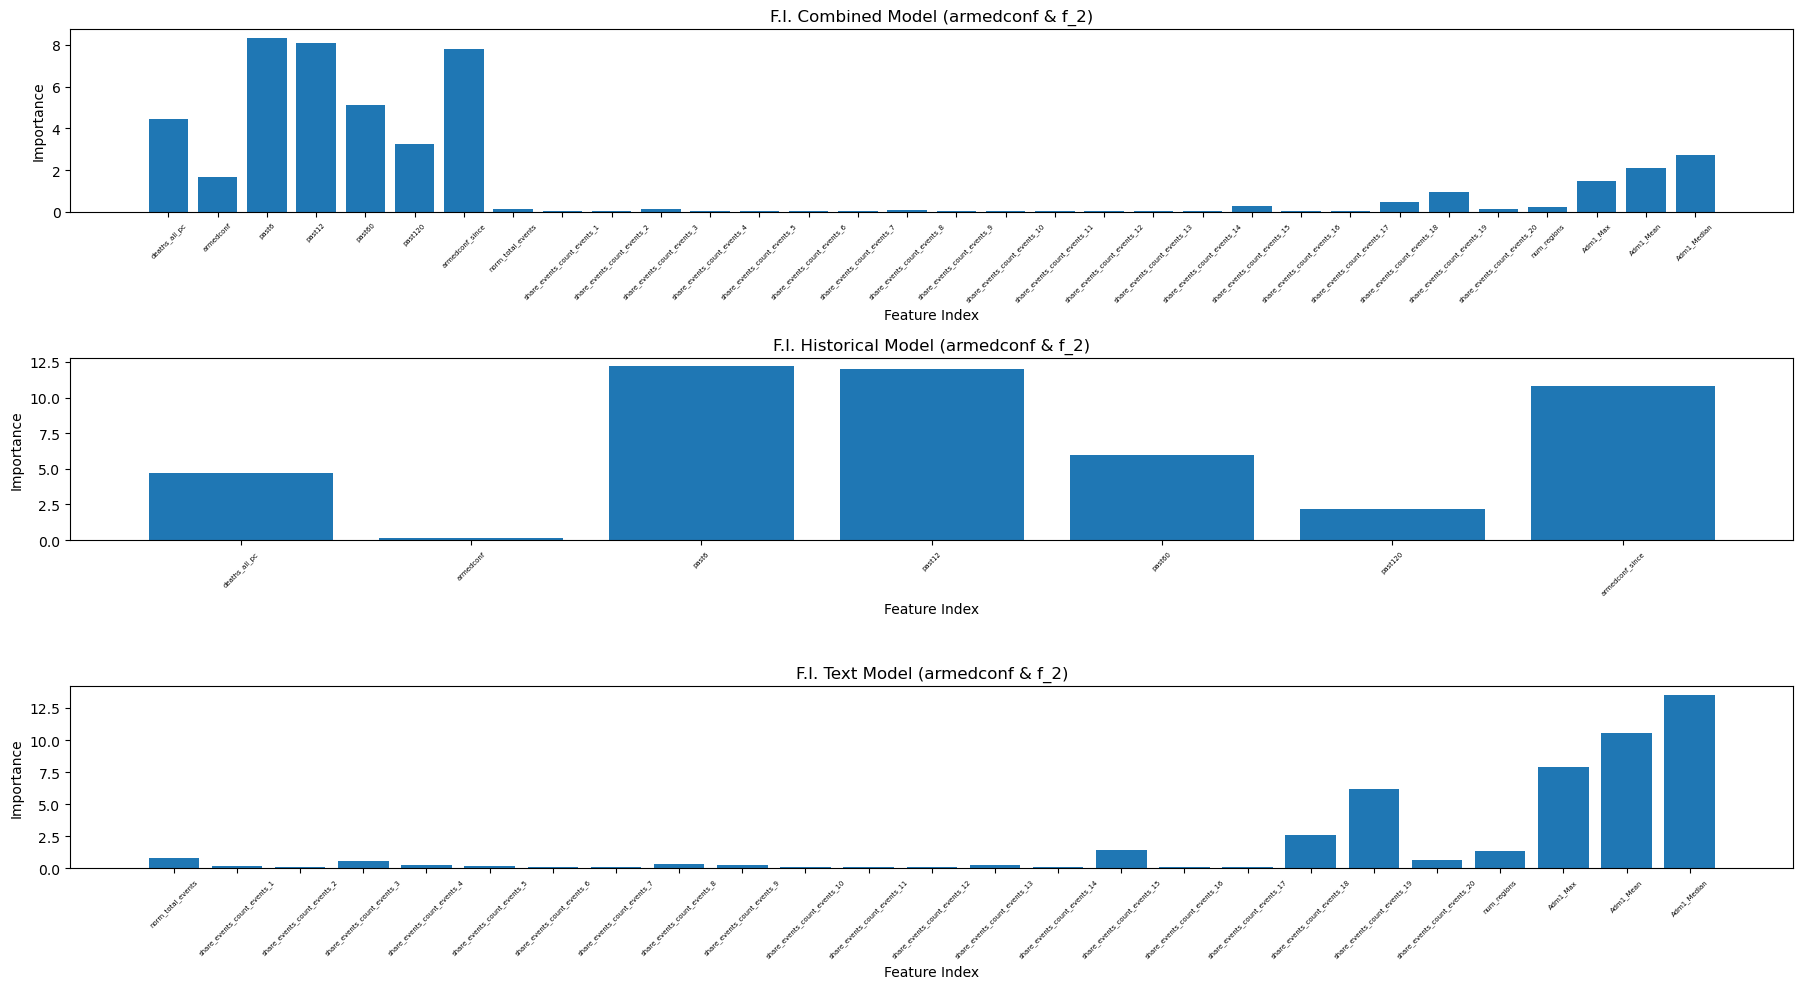

In [578]:
for dep in [target_clsf]: # we only have one dependent variable: stock price changes

    for forward,depth in zip(fwd,dpths):

        #for dp in depths:
        for forward in fwd:

            fittedframe = pd.DataFrame(columns=id_var + time_var)

            print(f'For target {dep}: checking forward {forward} with depth {depth}')
            
            print('Setting parameters')
            clf_all = setparams_clsf(trees, depth, min_samples_splits, min_samples_leafs)
            clf_hs = setparams_clsf(trees, depth, min_samples_splits, min_samples_leafs)
            clf_tx = setparams_clsf(trees, depth, min_samples_splits, min_samples_leafs)

            # to keep track of feature importances for each model (all, hs, tx)
            accumulated_importances_all = [0] * combomodel_var_len
            accumulated_importances_hs = [0] * historymodel_var_len
            accumulated_importances_tx = [0] * textmodel_varl_len

            
            # generates list of all working days between start and end date  
            #business_day_dates = generate_business_day_dates(startdate_id, end_date, [])

            # generate list of all months between start and end date
            future_months = generate_monthly_dates(start_month_year, end_month_year)
    
            for current_date in future_months:
                print('Month: ', current_date)
                
                # prepare slice for the current year and dep variable
                X_all, X_hs, X_tx, y, X_fut_all, X_fut_hs, X_fut_tx, df_all, df_hs, df_tx, df_fut_all, df_fut_hs, df_fut_tx  = prepare_slice(prepped_data, current_date, dep, forward, binary = True)

                # fit the model to the relevant X and y data
                clf_all.fit(X_all, y) # .astype(int) - when using classifier
                clf_hs.fit(X_hs, y)
                clf_tx.fit(X_tx, y)

                # add feature importances to the accumulated list
                importances_all = clf_all.feature_importances_
                importances_hs = clf_hs.feature_importances_
                importances_tx = clf_tx.feature_importances_

                accumulated_importances_all += importances_all
                accumulated_importances_hs += importances_hs
                accumulated_importances_tx += importances_tx

                # predict the future data for each model
                results_all = clf_all.predict_proba(X_fut_all) # predict_proba(X_fut_all) - when using classifier
                results_hs = clf_hs.predict_proba(X_fut_hs)
                results_tx = clf_tx.predict_proba(X_fut_tx)

                # prepare data frames and add the prediction results for each model 
                pred_fut_all = df_fut_all[id_var + time_var]
                pred_fut_hs = df_fut_hs[id_var + time_var]
                pred_fut_tx = df_fut_tx[id_var + time_var]

                pred_fut_all[f'pred_{dep}_f{forward}_all'] = results_all[:,1] # if predict_proba [:,1]
                pred_fut_hs[f'pred_{dep}_f{forward}_hs'] = results_hs[:,1]
                pred_fut_tx[f'pred_{dep}_f{forward}_tx'] = results_tx[:,1]

                # comnbine the results
                pred_future=pd.merge(pred_fut_all,pred_fut_hs,on=id_var+time_var,how='outer')
                pred_future=pd.merge(pred_future,pred_fut_tx,on=id_var+time_var,how='outer')
                
                # add each year's results to the fittedframe:
                fittedframe=pd.concat([fittedframe,pred_future])
            
            # save predictions for three models to csv before moving to next target (dep) and shifter (forward)
            fittedframe.to_csv(f"predictions_clsf_f{forward}_d{depth}_{dep}.csv")
            print('Saved predictions for forward ', forward, ' and depth ', depth, ' and target ', dep, 'to directory', os.getcwd())

            # plot feature importances for each model
            fig, axs = plt.subplots(3, 1, figsize=(18, 10))
        
            feature_labels_all = X_all.columns
            feature_labels_hs = X_hs.columns
            feature_labels_tx = X_tx.columns

            axs[0].bar(range(combomodel_var_len), accumulated_importances_all)
            axs[0].set_xlabel('Feature Index')
            axs[0].set_ylabel('Importance')
            axs[0].set_title(f'F.I. Combined Model ({dep} & f_{forward})')
            axs[0].set_xticks(range(combomodel_var_len), feature_labels_all,rotation=45, fontsize=5)

            axs[1].bar(range(historymodel_var_len), accumulated_importances_hs)
            axs[1].set_xlabel('Feature Index')
            axs[1].set_ylabel('Importance')
            axs[1].set_title(f'F.I. Historical Model ({dep} & f_{forward})')
            axs[1].set_xticks(range(historymodel_var_len), feature_labels_hs, rotation=45, fontsize=5)

            axs[2].bar(range(textmodel_varl_len), accumulated_importances_tx)
            axs[2].set_xlabel('Feature Index')
            axs[2].set_ylabel('Importance')
            axs[2].set_title(f'F.I. Text Model ({dep} & f_{forward})')
            axs[2].set_xticks(range(textmodel_varl_len), feature_labels_tx, rotation=45, fontsize=5)
            
            plt.tight_layout()
            plt.show()


## Metrics
- Metrics for classifier (ROC & Precision-Recall)
- Metrics for regressor (RMSE)

### Metrics for regressor

In [517]:
# Allows us to obtain the predictions for a given target and original shifted data

def get_tar_pred(df: pd.DataFrame() , fwd: int, model: str, start_time: dt, target: str):
    
    target_col = f'target_regr_f{fwd}'
    pred_col = f'pred_{target}_f{fwd}_{model}'

    df = df[[unit_of_analyis, 'date_str', target_col, pred_col]] 
    df['month_year'] = pd.to_datetime(df['date_str'])
    df = df[df.month_year >= start_time]
    df = df.dropna()

    y_preds = df[pred_col]
    y_trues = df[target_col]

    return y_trues, y_preds

In [518]:
# load all predictions and combined them into one dataframe
#pred_f1 = pd.read_csv(os.path.abspath(path + '/preds/2018only_regr_since2000/predictions_f1_d8_conflict.csv'))
#pred_f1 = pd.read_csv(os.path.abspath(path + '/predictions_f1_d8_deaths_pc.csv'))

pred_f1 = pd.read_csv(os.path.abspath(path + '/predictions_regr_f1_d8_deaths_pc.csv'))
pred_f1.drop('Unnamed: 0', axis=1, inplace=True)

pred_f2 = pd.read_csv(os.path.abspath(path + '/predictions_regr_f2_d8_deaths_pc.csv'))
pred_f2.drop('Unnamed: 0', axis=1, inplace=True)
print(pred_f1.shape, pred_f2.shape)

pred_vals_regr = pd.merge(pred_f1, pred_f2, on=[unit_of_analyis, 'month_year'], how='outer')
#pred_vals_regr = pred_f1


(9360, 5) (9360, 5)


In [519]:
# get original values and generate relevant target columns (for classification do this with make_target function)

og_vals = prepped_data.copy()
cols_to_keep = ['month_year', unit_of_analyis, target_regr] 
og_vals = og_vals[cols_to_keep]

fwds = [1,2]
for fwd in fwds:
        #og_vals = make_target(og_vals, fwd, target_clsf)
        og_vals[f'target_regr_f{fwd}'] = og_vals.groupby(unit_of_analyis)[target_regr].shift(-fwd)


# drop training data values
og_vals = og_vals[og_vals['month_year'] >= start_month_year]

# drop months not inlcuded in prediction range
og_vals = og_vals[og_vals['month_year'] <= end_month_year]

print(og_vals.shape, pred_vals_regr.shape)


(9360, 5) (9360, 8)


In [520]:

# Because it didn't like merging on the date column, I made a string version of Date
pred_vals_regr['date_str'] = pred_vals_regr['month_year'].astype(str)
og_vals['date_str'] = og_vals['month_year'].astype(str)

og_vals.drop('month_year', axis=1, inplace=True)
pred_vals_regr.drop('month_year', axis=1, inplace=True)

pred_all_regr = pd.merge(og_vals, pred_vals_regr, on=['date_str', unit_of_analyis], how='outer')
pred_all_regr

,isocode,deaths_pc,target_regr_f1,target_regr_f2,date_str,pred_deaths_pc_f1_all,pred_deaths_pc_f1_hs,pred_deaths_pc_f1_tx,pred_deaths_pc_f2_all,pred_deaths_pc_f2_hs,pred_deaths_pc_f2_tx
0,AFG,48.382546,40.641338,39.332965,2018-01-01,109.321300,108.985486,16.593090,123.792712,122.385439,21.250712
1,AGO,0.000000,0.000000,0.031976,2018-01-01,0.103181,0.112367,0.021909,0.182961,0.194637,0.045709
2,ALB,0.000000,0.000000,0.000000,2018-01-01,0.007029,0.005465,0.137583,0.011794,0.009132,0.187738
3,ARE,0.000000,0.000000,0.000000,2018-01-01,0.006755,0.005668,0.024124,0.012681,0.009921,0.044779
4,ARG,0.000000,0.000000,0.000000,2018-01-01,0.007290,0.005465,0.067238,0.011734,0.009132,0.105410
...,...,...,...,...,...,...,...,...,...,...,...
9355,XKX,0.000000,0.000000,0.000000,2021-12-01,0.027243,0.004954,0.088201,0.016148,0.007450,0.186851
9356,YEM,38.870110,5.215023,14.917390,2021-12-01,61.460506,66.780384,7.834759,91.352385,87.476550,17.416105
9357,ZAF,0.000000,0.016837,0.016837,2021-12-01,0.113746,0.213627,0.210457,0.191247,0.424515,0.310777
9358,ZMB,0.000000,0.000000,0.000000,2021-12-01,0.006046,0.004954,0.203397,0.010480,0.007450,0.241467


In [521]:
target = target_regr
fwds = [1,2]
models = ['all', 'hs', 'tx']

start_date = start_date ##start_date = dt.datetime(2018, 1, 2)

errors = {}

for fwd in fwds:
    for model in models:
            
            y_trues, y_preds = get_tar_pred(pred_all_regr, fwd, model, start_date, target_regr)
        
            errors[f'{model}_{fwd}'] = mean_squared_error(y_trues, y_preds)

print('All Root Mean Squared Errors:')
print(pd.Series(errors)) #.sort_values()

All Root Mean Squared Errors:
all_1    34.536005
hs_1     34.858765
tx_1     42.512232
all_2    64.611120
hs_2     64.630842
tx_2     55.015521
dtype: float64


### Metrics for classifier

In [503]:
# Allows us to obtain the predictions for a given target and original shifted data

def get_tar_pred(df: pd.DataFrame() , fwd: int, model: str, start_time: dt, target: str):
    
    target_col = f'target_clsf_f{fwd}'
    pred_col = f'pred_{target}_f{fwd}_{model}'

    df = df[[unit_of_analyis, 'date_str', target_col, pred_col]] 
    df['month_year'] = pd.to_datetime(df['date_str'])
    df = df[df.month_year >= start_time]
    df = df.dropna()

    y_preds = df[pred_col]
    y_trues = df[target_col]

    return y_trues, y_preds

In [504]:
# load all predictions and combined them into one dataframe and join with og_vals
#pred_f1 = pd.read_csv(os.path.abspath(path + '/preds/2018only_clsf_20_since2000/predictions_f1_d8_conflict.csv'))
pred_f1 = pd.read_csv(os.path.abspath(path + '/predictions_clsf_f1_d8_conflict.csv'))
pred_f1.drop('Unnamed: 0', axis=1, inplace=True)
pred_f2 = pd.read_csv(os.path.abspath(path + '/predictions_clsf_f2_d8_conflict.csv'))
pred_f2.drop('Unnamed: 0', axis=1, inplace=True)
print(pred_f1.shape, pred_f2.shape)

pred_vals_clsf = pd.merge(pred_f1, pred_f2, on=[unit_of_analyis, 'month_year'], how='outer')

(9360, 5) (9360, 5)


In [505]:
# get original values and generate relevant target columns (for classification do this with make_target function)
og_vals = prepped_data.copy()
cols_to_keep = ['month_year', unit_of_analyis, target_clsf] 
og_vals = og_vals[cols_to_keep]

fwds = [1,2]
for fwd in fwds:
        og_vals = make_target(og_vals, fwd, target_clsf)


# drop training data values
og_vals = og_vals[og_vals['month_year'] >= start_month_year]

# drop months not inlcuded in prediction range
og_vals = og_vals[og_vals['month_year'] <= end_month_year]

print(og_vals.shape, pred_vals_clsf.shape)

og_vals


(9360, 5) (9360, 8)


,month_year,isocode,conflict,target_clsf_f1,target_clsf_f2
77245,2018-01-01,AFG,1,1.0,1.0
77246,2018-01-01,AGO,0,0.0,0.0
77248,2018-01-01,ALB,0,0.0,0.0
77250,2018-01-01,ARE,0,0.0,0.0
77251,2018-01-01,ARG,0,0.0,0.0
...,...,...,...,...,...
88613,2021-12-01,XKX,0,0.0,0.0
88614,2021-12-01,YEM,1,0.0,0.0
88615,2021-12-01,ZAF,0,0.0,0.0
88616,2021-12-01,ZMB,0,0.0,0.0


In [506]:
# Because it didn't like merging on the date column, I made a string version of Date
pred_vals_clsf['date_str'] = pred_vals_clsf['month_year'].astype(str)
og_vals['date_str'] = og_vals['month_year'].astype(str)

og_vals.drop('month_year', axis=1, inplace=True)
pred_vals_clsf.drop('month_year', axis=1, inplace=True)


pred_all_clsf = pd.merge(og_vals, pred_vals_clsf, on=['date_str', unit_of_analyis], how='outer')

In [507]:
pred_all_clsf.columns # 'pred_target_clsf_f1_all'

Index(['isocode', 'conflict', 'target_clsf_f1', 'target_clsf_f2', 'date_str',
       'pred_conflict_f1_all', 'pred_conflict_f1_hs', 'pred_conflict_f1_tx',
       'pred_conflict_f2_all', 'pred_conflict_f2_hs', 'pred_conflict_f2_tx'],
      dtype='object')

In [510]:
def get_roc_pr(df_og: pd.DataFrame, fwd: int, target: str, models: list, staryearid, binary=True, plot=True):
    """Function to return the roc and pr values for a given target, level and forward period"""
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    for model in models:

        y_true, y_pred = get_tar_pred(df_og, fwd, model, staryearid, target)
    
        roc = roc_auc_score(y_true, y_pred)
        pr = average_precision_score(y_true, y_pred)
    
        # Compute the FPR & TPR and calculate the AUC
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
    
        # Compute precision, recall, and thresholds for PR curve
        precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred)
    
        print('ROC:', round(roc, 3), 'Precision:', round(pr, 3))
    
        # Plot ROC curve
        axs[0].plot(fpr, tpr, lw=2, label=f'ROC curve {model} (area = {roc_auc:.2f})')
    
        # Plot precision-recall curve
        axs[1].plot(recall, precision, lw=2, label=f'Precision-Recall curve {model} (prec: {pr:.2f})')
    
        axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[0].set_xlim([0.0, 1.0])
        axs[0].set_ylim([0.0, 1.05])
        axs[0].set_xlabel('False Positive Rate (FP/(FP+TN))')
        axs[0].set_ylabel('True Positive Rate/Recall (TP/(TP+FN))')
        axs[0].set_title(f'ROCs for {target} {fwd} month(s) ahead')
        axs[0].legend(loc="lower right")
        
        axs[1].set_xlabel('Recall (TP/(TP+FN))')
        axs[1].set_ylabel('Precision (TP/(TP+FP))')
        axs[1].set_title('Precision-Recall Curve')
        axs[1].legend(loc="upper right")
        
        plt.tight_layout()
    plt.show()

#get_roc_pr_2(pred_all, 2, 'med_incr', ['all', 'hs', 'tx'], 2015, binary=True, plot=True)

conflict f_1
ROC: 0.982 Precision: 0.276
ROC: 0.948 Precision: 0.245
ROC: 0.983 Precision: 0.284


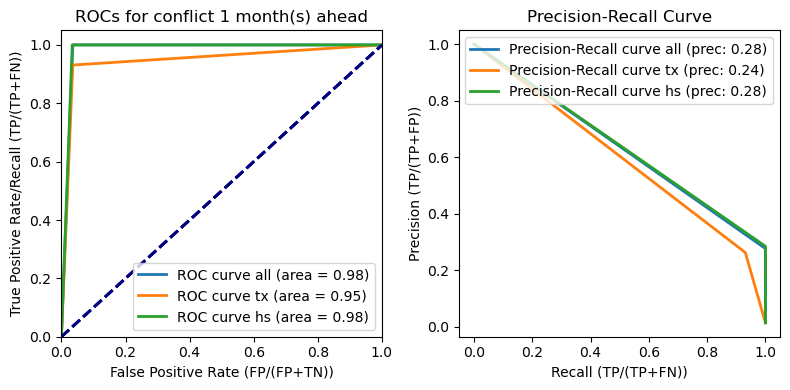

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
conflict f_2
ROC: 0.98 Precision: 0.289
ROC: 0.921 Precision: 0.223
ROC: 0.98 Precision: 0.282


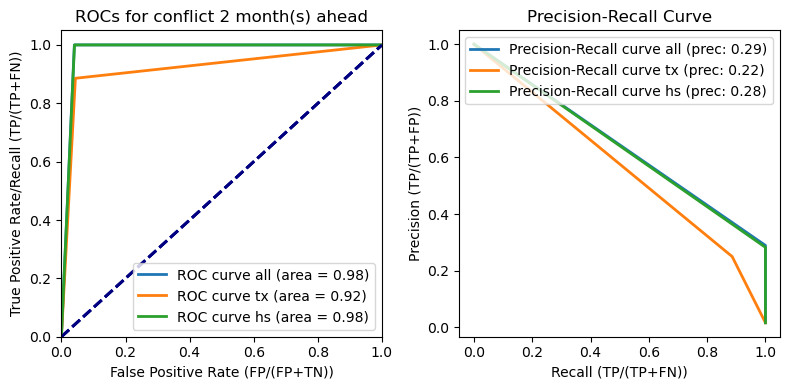

- - - - -- - - - - - - - - - - - - - - - - - - - - - 


In [511]:
for target in [target_clsf]:
    for sft in [1,2]:
        print(target, f'f_{sft}') #, model)
        get_roc_pr(pred_all_clsf, sft, target, ['all', 'tx', 'hs'], start_month_year, True, True)
        print('- - - - -- - - - - - - - - - - - - - - - - - - - - - ')